In [ ]:
!pip install cirq

In [ ]:
!pip install ortools

In [ ]:
import numpy as np
import random
import time
import itertools as itert
import matplotlib.pyplot as plt
import cirq
from tqdm.notebook import tqdm


**Simons**'s

In [ ]:
def getFx(n,verbose):  
  s = np.random.randint(2, size = n) # Generate s for the funct 
  # print(sum(s))
  # s = 0 
  funct = ["0" for i in range(2**n)] #initialise the mapping of funct 
  # if s = [0]^n, then simply make a one to one mapping from input to putput space
  if(sum(s)==0):
      tot = []
      for i in range(2**(n)):
          val = bin(i)[2:].zfill(n)
          tot.append(val)

      funct = np.random.permutation(tot) 
      if(verbose): 
        print("Function show")
      str_s = [str(int) for int in s]
      str_s = "".join(str_s)
      if(verbose): 
        print("Function is created with s = " + str_s)
        print("Input, Output")
      for i in range(2**(n)):
        val = bin(i)[2:].zfill(n)
        if(verbose):
          print(val,funct[i])
  

  # if s!=[0]^n, then create a 2 to 1 mapping function    
  else:
      tot = [] # storing function mappins
      mull = np.ones(n)
      twos = 1
      for i in range(n):
          mull[-1-i] = twos
          twos *= 2
      s_int = int(np.dot(mull,s))   # get the s value in integer form  
      for i in range(2**(n)):
          val = bin(i)[2:].zfill(n)
          tot.append(val)
      tot = np.asarray(tot)    
      tot = np.random.permutation(tot) # permute to ensure randomization
      coun = 0
      # iterate over all input space, and sequentially put "tot" contents as mapping for the function. Everytime get the XOR of the iterating index i and 
      # map that to the same value too.
      
      for i in range(2**(n)):
          compl = s_int ^ i # get the XOR of i with s to get the other input for which output is same
          if(funct[i]=="0"):
              vaa = tot[coun]
              #assign vaa to both indices
              funct[i] = vaa 
              funct[compl] = vaa
              coun += 1
      if(verbose):         
        print("Function show")
      str_s = [str(int) for int in s]
      str_s = "".join(str_s)
      if(verbose): 
        print("Function is created with s = " + str_s)
        print("Input, Output")
      for i in range(2**(n)):
        val = bin(i)[2:].zfill(n)
        if(verbose): 
          print(val,funct[i])
  return funct     


In [ ]:

# Generate Uf matrix by iteratig over all possible inputs and calling the function, and doing XOR with helper bits. Set the corresponding entry in Uf matrix to 1.
def createUf(n,func):
    ufMatrix = np.zeros((2**n,2**n))
    for i in range(2**(n)):
        val = bin(i)[2:].zfill(n)
        x = val[:int(n/2)]
        b = val[int(n/2):]
       
        b = np.asarray(list(map(int,str(int(func[int(x,2)])+int(b)))))
        b[np.where(b==2)] = 0
        
        b = (''.join(map(str, b)))
        b = b.zfill(int(n/2))
        

        output = x+b
       
        ufMatrix[int(output,2)][int(val,2)] = 1
    return  ufMatrix  

# Oracle to generate the quantum gate given the Uf matrix        
class Oracle(cirq.Gate):
    def __init__(self, n, ufMatrix, name):
        self.__n = n
        self.__ufMatrix = ufMatrix
        self.__name = name

    def num_qubits(self):
        return self.__n 

    def _unitary_(self):
        return np.squeeze(np.asarray(self.__ufMatrix))
        
    def __str__(self):
        return self.__name

In [ ]:
# function to verify the Uf matrix. iterate over all possible inputs
def ver(n):
  func = getFx(n,True)
  kk = createUf(2*n,func)
  dd = "".join(list(map(str,np.zeros(n, dtype=int))))
 
  for i in range(2**n):
    val = bin(i)[2:].zfill(n)
    val2 = val + dd
    print("Checking Input", val2)
    real = val+func[i]

    inp = np.zeros(2**(2*n))
    inp[int(val2,2)] = 1
    out = kk@inp
    pred = np.where(out==1)[0][0]
   
    if(int(real,2)!=pred):
      print("Error")
      print("For Input:", val)
      print("Correct value :", int(real,2),"Generated value : ", pred)
    else:
      print("Correct")  




In [ ]:
ver(2)

Function show
Function is created with s = 01
Input, Output
00 10
01 10
10 00
11 00
Checking Input 0000
Correct
Checking Input 0100
Correct
Checking Input 1000
Correct
Checking Input 1100
Correct


In [ ]:
from ortools.sat.python import cp_model
# class to give all possible solutions of SAT problem
class sat_solve_multiple(cp_model.CpSolverSolutionCallback):

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.sols = []

    def on_solution_callback(self):
        tem = []
        for v in self.__variables:
            tem.append(self.Value(v))
            self.sols.append(tem)
      
#SAT solver to solve the system of linear equations. Model using XOR gates. First n variables are declared which is length of s. Constraints are then added, and finally solver is used.
def SAT_Solver(arr):
    """Minimal CP-SAT example to showcase calling the solver."""
    model = cp_model.CpModel()

    s_len = arr.shape[1]
    num_eq = arr.shape[0]
   
    lis = []
   
    for i in range(s_len):
      lis.append(model.NewIntVar(0, 1, 'x{}'.format(i)))
   
    for i in range(num_eq):
      tem = []
      for j in range(s_len):
        if(arr[i][j]==1):
          tem.append(lis[j])
      tem.append(1)  
      model.AddBoolXOr(tem) 

    solver = cp_model.CpSolver()
    solution_printer = sat_solve_multiple(lis)
    solver.parameters.enumerate_all_solutions = True
    status = solver.Solve(model,solution_printer)
    final = solution_printer.sols[-1]
    return("".join(map(str,final)))

In [ ]:
def runMainCircuit(n,verbose = True):

    # Taking the input n from the user
    if(n == 0):
        n = int(input("Enter length of function input: "))
    else:
      if(verbose):
        print('Input Length: ', n)
    
    #generate qubits line
    qubits = cirq.LineQubit.range(2*n)
   
    c = cirq.Circuit()
    # generate the function
    func = getFx(n,verbose)
    #solve for case of n=1
    if(n==1):
      if(func[0]!=func[1]):
        s = 0
        print("Predicted s = ",s)
        return 0,0,0
      else:
        s = 1
        print("Predicted s = ",s)
        return 0,0,0

 

    start = time.time()
    
    #create uf matrix
    uf = createUf(2*n,func)
    #create the oracle gate
    ufo = Oracle(2*n, uf, "Uf")
    #create the circuit
    for i in range(0,int(n)):
        c.append([cirq.H(qubits[i])])
    
     
    c.append(ufo(*qubits))
    

    for i in range(0,n):
        c.append([cirq.H(qubits[i])])
    
    # Adding measurement gates 
    for i in range(0,n):
        c.append(cirq.measure(qubits[i]))
   
    if(verbose):
      print("Circuit used to solve problem: ")
      print(c)
    mid = time.time()

    simulator = cirq.Simulator()
    
    flag = 0
    count = 0
    while(flag==0):
      result = simulator.run(c, repetitions = (n-1))
      dic = result._measurements
      bit_strings = np.asarray(list(dic.values())).squeeze().T
      if(n==2):
        bit_strings = np.expand_dims(bit_strings,0)
      #check rank of bit string matrix  
      count += 1
      if(np.linalg.matrix_rank(bit_strings)==(n-1)):
        mid2 = time.time()
        #solve using SAT solver
        s = SAT_Solver(bit_strings)
        verify = int(s,2)
        # case to handle s=0
        if(func[0]==func[verify]):
          if(verbose):
            print("\n")
            print("Predicted s = ",s)
          flag = 1
        else:
          s = "".join(map(str,np.zeros(n,dtype=int)))
          if(verbose):
            print("\n")
            print("Predicted s = ",s)
          flag = 1

      end = time.time()

    if(verbose):
      print("Time taken to create circuit: ", mid - start)
      print("Time taken for execution of quantum circuit: ", mid2 - mid)
      print("Time taken for executing classical parth: ", end - mid2)  
      print("Time taken for executing whole program: ", end - start)    

        
    return mid-start,mid2-mid,end-mid2,count

    

Correctness Test Cases:

In [ ]:
a,b,c,d = runMainCircuit(3)


Input Length:  3
Function show
Function is created with s = 011
Input, Output
000 001
001 010
010 010
011 001
100 110
101 011
110 011
111 110
Circuit used to solve problem: 
0: ───H───Uf───H───M───
          │
1: ───H───#2───H───M───
          │
2: ───H───#3───H───M───
          │
3: ───────#4───────────
          │
4: ───────#5───────────
          │
5: ───────#6───────────


Predicted s =  011
Time taken to create circuit:  0.013279438018798828
Time taken for execution of quantum circuit:  0.016387939453125
Time taken for executing classical parth:  0.004014015197753906
Time taken for executing whole program:  0.033681392669677734


In [ ]:
a,b,c,d = runMainCircuit(4)

Input Length:  4
Function show
Function is created with s = 0100
Input, Output
0000 0001
0001 1111
0010 0010
0011 0111
0100 0001
0101 1111
0110 0010
0111 0111
1000 1000
1001 1101
1010 0100
1011 1011
1100 1000
1101 1101
1110 0100
1111 1011
Circuit used to solve problem: 
0: ───H───Uf───H───M───
          │
1: ───H───#2───H───M───
          │
2: ───H───#3───H───M───
          │
3: ───H───#4───H───M───
          │
4: ───────#5───────────
          │
5: ───────#6───────────
          │
6: ───────#7───────────
          │
7: ───────#8───────────


Predicted s =  0100
Time taken to create circuit:  0.027026653289794922
Time taken for execution of quantum circuit:  0.023904800415039062
Time taken for executing classical parth:  0.0016241073608398438
Time taken for executing whole program:  0.05255556106567383


In [ ]:
a,b,c,d = runMainCircuit(5)

Input Length:  5
Function show
Function is created with s = 10110
Input, Output
00000 11000
00001 10001
00010 01001
00011 00111
00100 00011
00101 11100
00110 11101
00111 11001
01000 00110
01001 01011
01010 10110
01011 01110
01100 10010
01101 00101
01110 01000
01111 00001
10000 11101
10001 11001
10010 00011
10011 11100
10100 01001
10101 00111
10110 11000
10111 10001
11000 01000
11001 00001
11010 10010
11011 00101
11100 10110
11101 01110
11110 00110
11111 01011
Circuit used to solve problem: 
0: ───H───Uf────H───M───
          │
1: ───H───#2────H───M───
          │
2: ───H───#3────H───M───
          │
3: ───H───#4────H───M───
          │
4: ───H───#5────H───M───
          │
5: ───────#6────────────
          │
6: ───────#7────────────
          │
7: ───────#8────────────
          │
8: ───────#9────────────
          │
9: ───────#10───────────


Predicted s =  10110
Time taken to create circuit:  0.037705183029174805
Time taken for execution of quantum circuit:  0.026372909545898438
Time

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

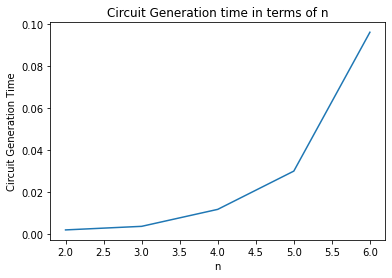

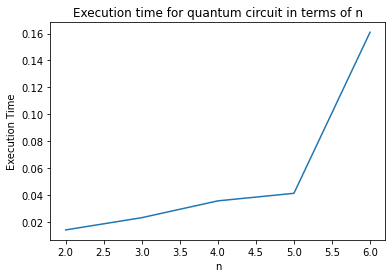

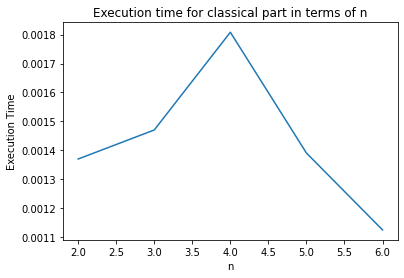

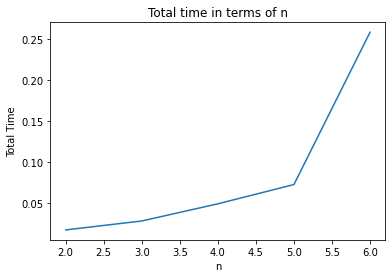

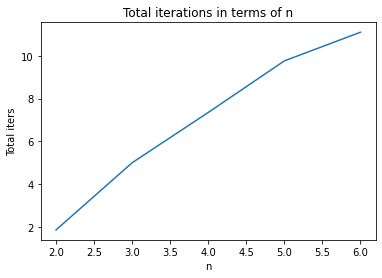

In [ ]:
circuitTimes = []
execution_quantum_Times = []
execution_classical_Times = []
totalTimes = []
total_counts = []
for n in range(2, 7):
    ct = 0
    etq = 0
    etc = 0
    tt = 0
    coun = 0
    for i in tqdm(range(100)):
        (circuit, execution_q, execution_c,count) = runMainCircuit(n, False)
        ct += circuit
        etq += execution_q
        etc += execution_c
        tt += circuit + execution_q + execution_c
        coun += count
    circuitTimes.append(ct / 100)
    execution_quantum_Times.append(etq / 100)
    execution_classical_Times.append(etc / 100)
    totalTimes.append(tt / 100)
    coun = coun*(n-1)
    # print(coun)
    total_counts.append(coun/100)


x_axis = [2, 3, 4, 5, 6]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time in terms of n')
plt.ylabel('Circuit Generation Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, execution_quantum_Times)
plt.title('Execution time for quantum circuit in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, execution_classical_Times)
plt.title('Execution time for classical part in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, totalTimes)
plt.title('Total time in terms of n')
plt.ylabel('Total Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, total_counts)
plt.title('Total iterations in terms of n')
plt.ylabel('Total iters')
plt.xlabel('n')
plt.show() 

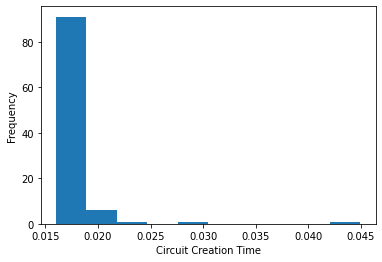

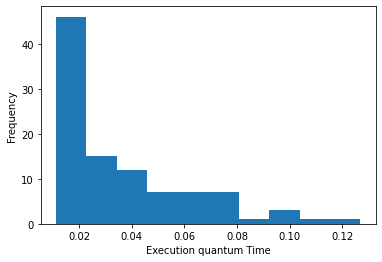

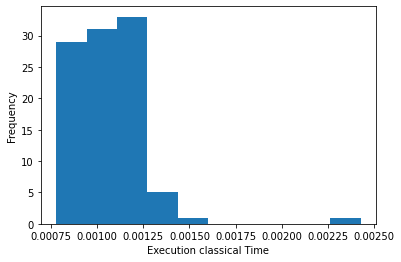

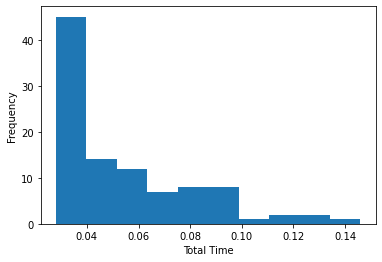

In [ ]:
circuitTimes = []
execution_quantum_Times = []
execution_classical_Times = []
totalTimes = []
for i in range(100):
    (circuit , execution_q, execution_c,_) = runMainCircuit(5, False)
    circuitTimes.append(circuit)
    execution_quantum_Times.append(execution_q)
    execution_classical_Times.append(execution_c)
    totalTimes.append(circuit + execution_q + execution_c)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(execution_quantum_Times)
plt.xlabel('Execution quantum Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(execution_classical_Times)
plt.xlabel('Execution classical Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.show() 